#### 1. Import Libraries and Data

- .as_numpy_iterator() method is a function in TensorFlow that allows you to convert a dataset into a Python iterator that yields batches of data in the form of NumPy arrays. This method is commonly used when you want to extract the data from a TensorFlow dataset and work with it in a more familiar NumPy array format.

In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
ds = tfds.load('fashion_mnist', split='train')

In [3]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

#### 2. Viz Data and Build Dataset

In [4]:
# Do some Data Transformation
import numpy as np

In [5]:
# Set-up a pipeline to get data
data_iterator = ds.as_numpy_iterator()

In [8]:
# This is just an individual subplots 
ax

array([<Axes: title={'center': '2'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '8'}>, <Axes: title={'center': '4'}>],
      dtype=object)

##### 2.1. Visualize a Batch

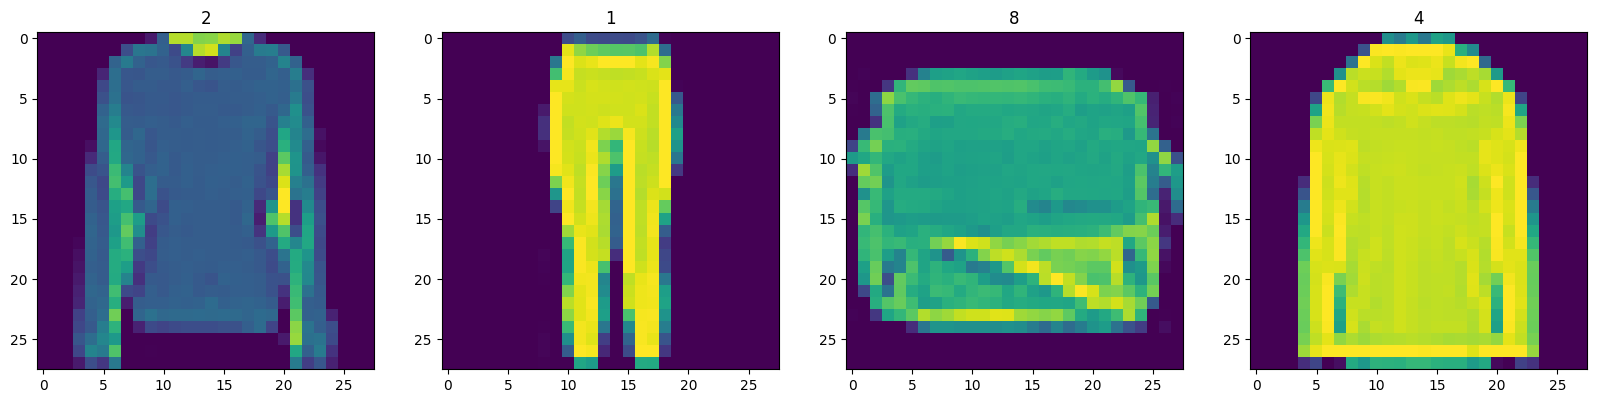

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    #this is to get one sample/batch which contains 2 keys('image', 'label')
    batch = data_iterator.next()
    # Reduce the dimension of img array
    ax[idx].imshow(np.squeeze(batch['image'])) 
    # Set the title of each as their label
    ax[idx].title.set_text(batch['label'])


##### 3. Rescale Images and Build Data Pipeline

- ds.map(scale_images)

This line applies the custom function scale_images to each element of the dataset ds using the map() function. The map() function is a powerful feature in TensorFlow that allows you to apply a function to each element of a dataset, transforming the data accordingly.

- ds.cache()

The cache() function is used to cache the elements of the dataset in memory after they have been loaded. This is a helpful optimization technique, especially when the dataset fits in memory, as it can significantly speed up data loading during subsequent iterations of the dataset.

- ds.shuffle(60000)

The shuffle() function shuffles the elements of the dataset randomly. The parameter 60000 represents the buffer size used for shuffling. The buffer size indicates the number of elements from the dataset to sample for shuffling. In this case, the buffer size is set to 60000, which is likely the size of the dataset. Setting the buffer size to be equal to or larger than the dataset size ensures that the entire dataset is shuffled thoroughly.

- ds.batch(64)

The batch() function groups elements of the dataset into batches. The parameter 64 indicates the batch size, meaning that each batch will contain 64 elements from the dataset (assuming the dataset size is a multiple of 64). Batching the data is essential for training neural networks, as it allows the model to process multiple samples together, which often results in more efficient computation during training.

- The prefetch()
  
function in TensorFlow is used to prefetch elements of a dataset, which means loading the next elements in the background while the current elements are being processed. This is a powerful technique to improve data pipeline performance, especially when dealing with large datasets and complex preprocessing.

In [9]:
# Rescale images b/w 0 and 1
def scale_images(data):
    image = data['image']
    return image / 255

In [10]:
# Build a data pipeline
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

#### 4. Build Neural Network
- For GAN's use LeakyRelu activation

In [11]:
# Import Modelling Components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout,LeakyReLU, UpSampling2D

##### 4.1. Build Generator
- 7x7x128 means 7 width 7 height 128 channels image that will be generated
- 128 is a random input variable
- we need to move our generator to generate 28x28x1 image

In [12]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes in 7x7x128
    # Beginings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D()) # Double the size of the input
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling Block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))  #?
    model.add(LeakyReLU(0.2)) 

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [13]:
gen_model = build_generator()
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

##### 4.1.1. Generate 4 sample images

In [14]:
img = gen_model.predict(np.random.randn(4,128,1))  # ?

1/1 [==============================] - 0s 253ms/step


##### 4.1.2. Visualize Generated Images By the generator

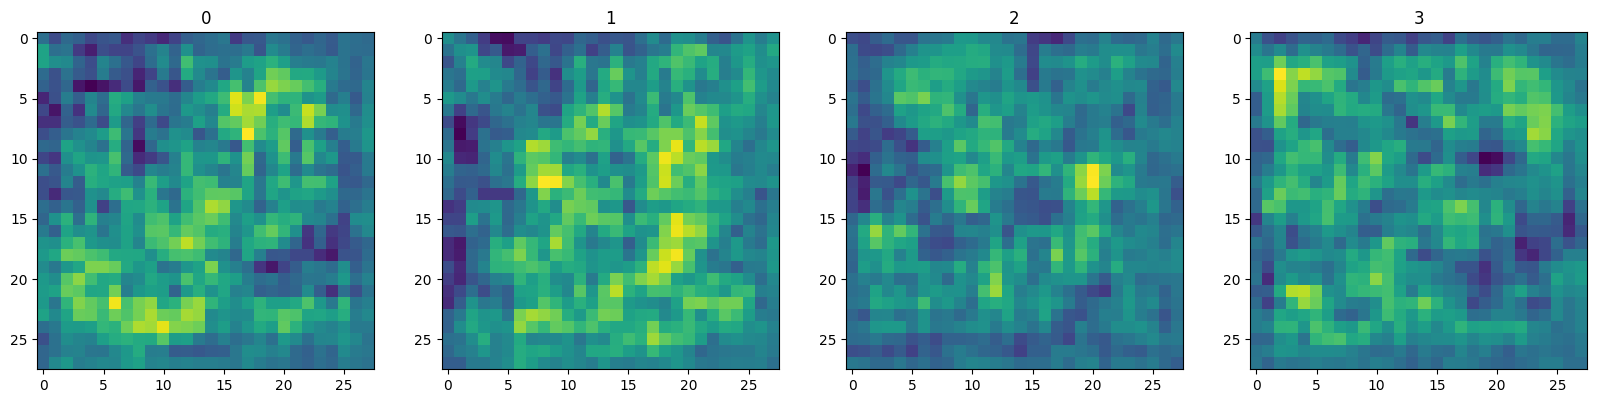

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img): #?
    # Reduce the dimension of img array
    ax[idx].imshow(np.squeeze(img)) 
    # Set the title of each as their label
    ax[idx].title.set_text(idx)


##### 4.2. Build Discriminator

In [16]:
def build_discriminator():
    model = Sequential()

    # Conv Block
    model.add(Conv2D(32, 5, input_shape= (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Conv Block 2
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Conv Block 3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Conv Block 4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass through Dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    # Sigmoid allows us to put the output between 0 and 1
    model.add(Dense(1, activation='sigmoid')) 


    return model

In [18]:
discrim_model = build_discriminator()
discrim_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)      

In [19]:
discrim_model.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 82ms/step


array([[0.49452478]], dtype=float32)

##### 5. Build Training Loop
- Training of GAN's is hard because, you need to find the balance between training of both generator and discriminator. otherwise the discriminator will know everytime if an image is fake or not
  - One way to do that is to inject noise to slow it down a little bit

##### 5.1. Setup Losses and Optimizers

In [20]:
# optimizer and loss for both models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

##### 5.2. Build Subclassed Model
- There are two ways to Do this
    - Use @tf.function, folowed by your custom train, compile or test step function.
    - Make a child class for this, which is being done here


In [22]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [23]:
# this child class  is inherited from the Base class "Model"
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Provides fuctionality from our base class keras
        super().__init__(*args, **kwargs)
        # Create attributes for Gen and Discrim
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create Attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss   

    # when you call model.fit(), this func is also called
    def train_step(self, batch):  
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False) # ?

        # Train The Discriminator
        # Calculate gradient
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create Labels for real and fake images
                # real images will be zero 
                # tf.zeros_like - generate set of zeros based on shape of input
                # tf.ones_like - generate set of Ones total 128 zeros and 128 ones
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
        
            # Calculate Loss - BinaryCrossEntropy
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - NN learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Create gradient for Generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create The predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate Loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss":total_g_loss}
    # For model.evaluate(), this function can be used
    #def test_step(self):

    


In [24]:
# Create Instance of a subclassed model
fashgan = FashionGAN(gen_model, discrim_model)

In [25]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

##### 5.3. Build Callback
Callback is optional but it helps monitoring your model

In [26]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [27]:
# Custom Callback
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

##### 5.4. Train

In [28]:
import tensorflow as tf
# this is used to avoid an error of first call or soemthing   ???
tf.config.run_functions_eagerly(True)

In [ ]:
# Recommended 2000 epochs 
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

##### 5.5. Review Performance

- according to the trained model you can plot the performance

##### 5.6. Test Out the Generator

In [29]:
# generate imgs
imgs = gen_model.predict(tf.random.normal((16, 128, 1)))
imgs

e:\usama\Machine Learning and AI\GAN's\env\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 202ms/step


array([[[[0.5006112 ],
         [0.49581674],
         [0.4963329 ],
         ...,
         [0.50780386],
         [0.5066959 ],
         [0.50320095]],

        [[0.50158846],
         [0.4983059 ],
         [0.49604976],
         ...,
         [0.50785875],
         [0.50824416],
         [0.506009  ]],

        [[0.4959488 ],
         [0.5006998 ],
         [0.50465554],
         ...,
         [0.5071911 ],
         [0.5068796 ],
         [0.50368744]],

        ...,

        [[0.49423602],
         [0.49609056],
         [0.5032505 ],
         ...,
         [0.5059499 ],
         [0.5047595 ],
         [0.50214064]],

        [[0.5008321 ],
         [0.5033254 ],
         [0.50486696],
         ...,
         [0.5010834 ],
         [0.5003172 ],
         [0.4992852 ]],

        [[0.49982202],
         [0.5024764 ],
         [0.5015068 ],
         ...,
         [0.50177604],
         [0.4994545 ],
         [0.499577  ]]],


       [[[0.49883133],
         [0.49940017],
         [0.50

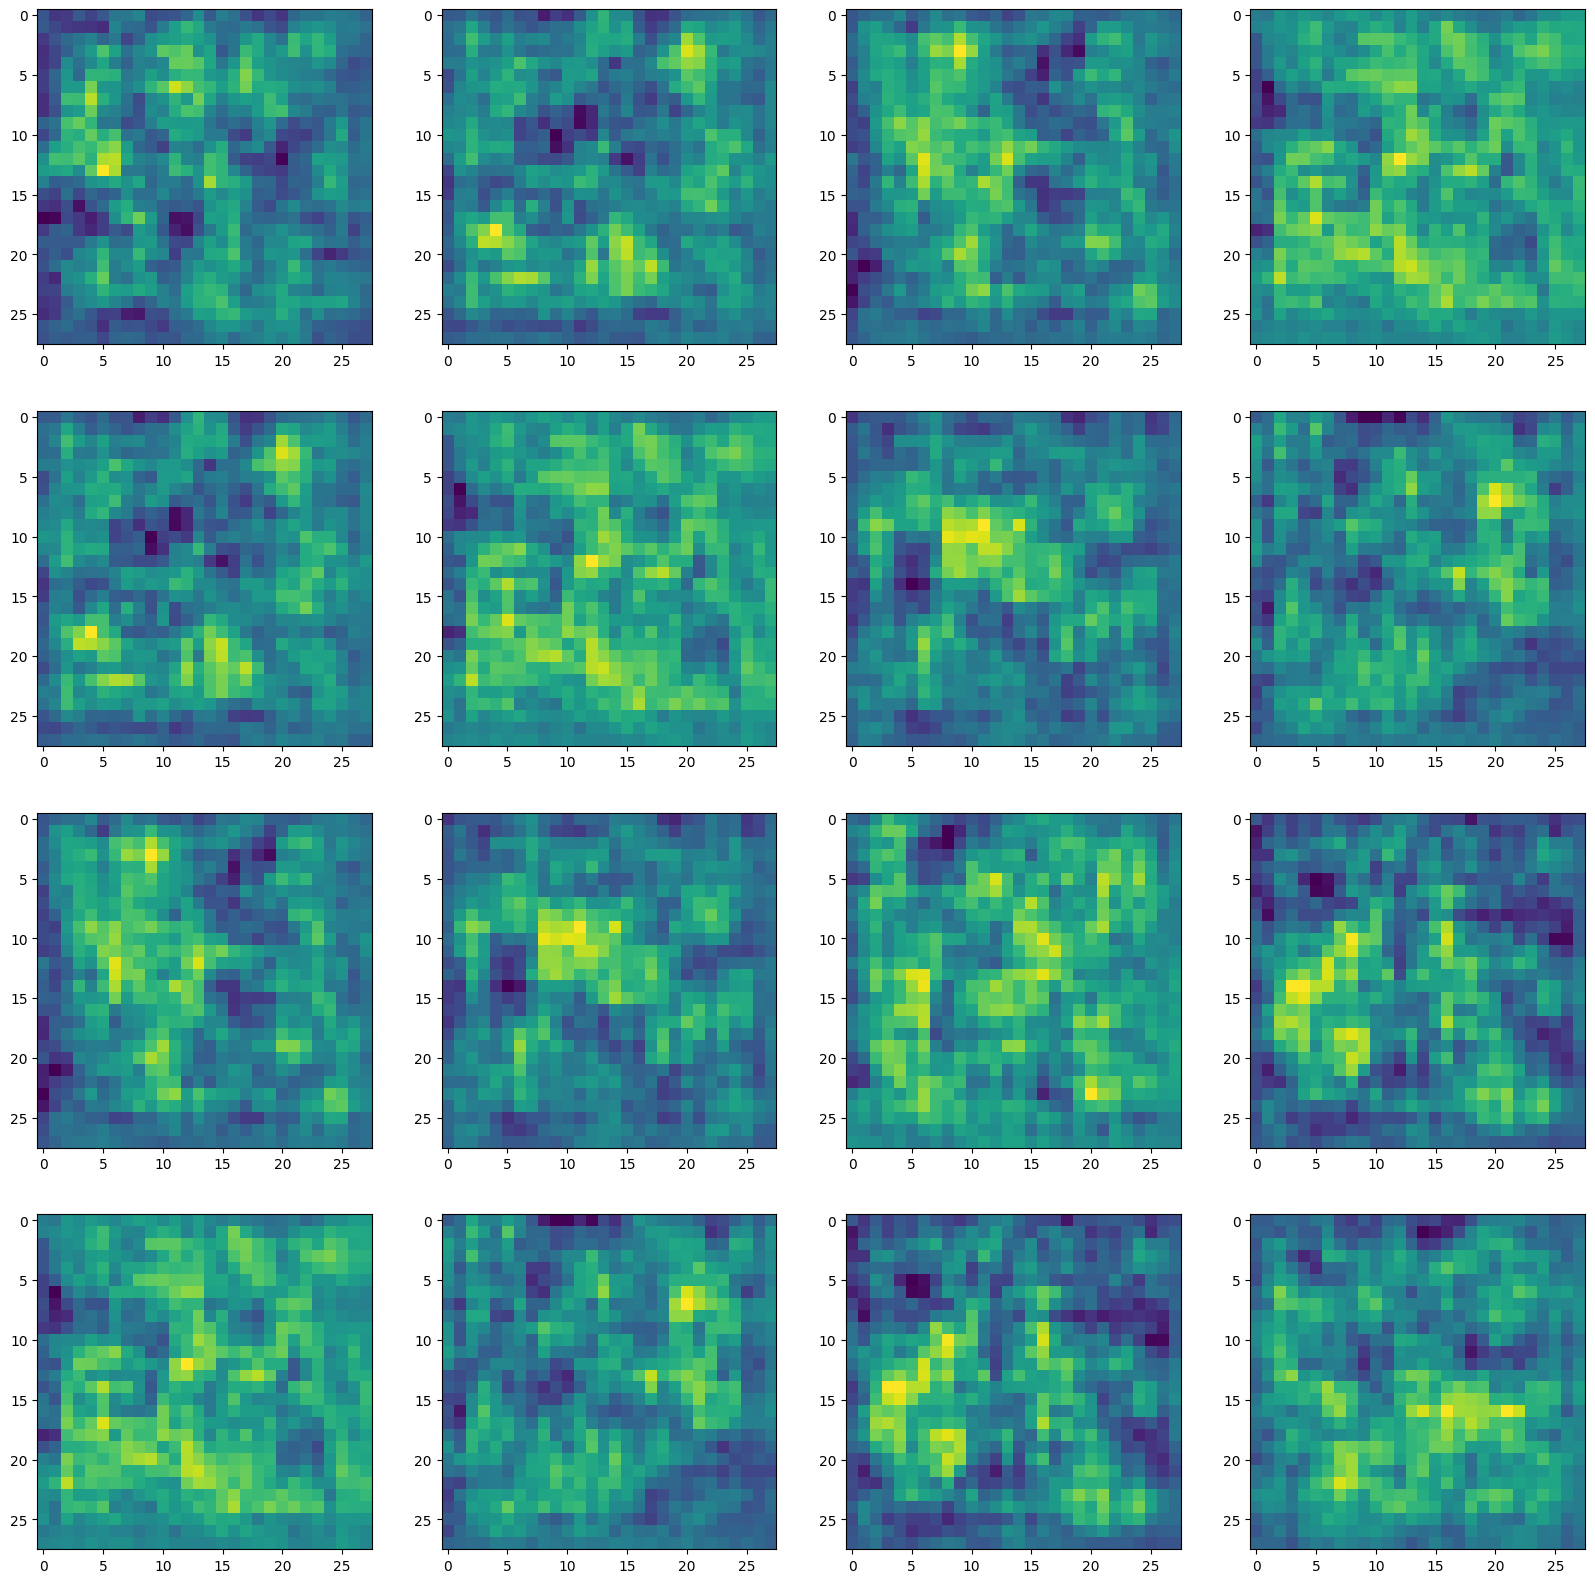

In [30]:
# Visualize imgs
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [31]:
# Use the pretrained (2000 epoch) generator model weights
gen_model.load_weights(os.path.join('model', 'generatormodel.h5'))

ValueError: axes don't match array